# [IAPR][iapr]: Project


**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 07.05.2021  
**Due date:** 03.06.2021 (23h59)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class as well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

### Import image

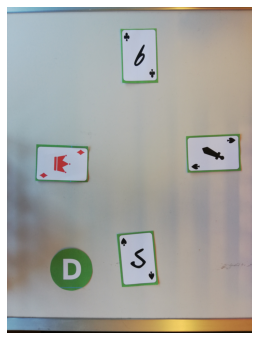

In [3]:
import os
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data_base_path = os.path.join(os.pardir, 'project/train_games')
data_folder = 'game1'

# Load image
data_path = os.path.join(data_base_path, data_folder)
image1 = skimage.io.imread(os.path.join(data_path, '2.jpg'))

# Display image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(image1)
ax.axis('off')
plt.show()

## Plot image channels

In [4]:
def crop(image, top=100, bottom=4400):
    return image[top:bottom, :, :]

In [5]:
image_cropped = crop(image1)
print(image_cropped.shape)

(4300, 3456, 3)


In [6]:
def decompose_channels(image):
    # Decompose image into greyscale and RGB channels
    
    gray = skimage.color.rgb2gray(image)
    red = image[:, :, 0]
    green = image[:, :,1]
    blue = image[:, :,2]
    
    return [gray, red, green, blue]

In [7]:
def plot_channels(images):
    # Plot the 4 channels of an image
    # Greyscale and RGB
    
    fig, axes = plt.subplots(1, 4, figsize=(12, 12))

    axes[0].imshow(images[0], cmap='gray')
    axes[0].set_title('Grayscale')
    axes[1].imshow(images[1], cmap='gray')
    axes[1].set_title('Red channel')
    axes[2].imshow(images[2], cmap='gray')
    axes[2].set_title('Green channel')
    axes[3].imshow(images[3], cmap='gray')
    axes[3].set_title('Blue channel')

    for i in range(4):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

## Pre-processing

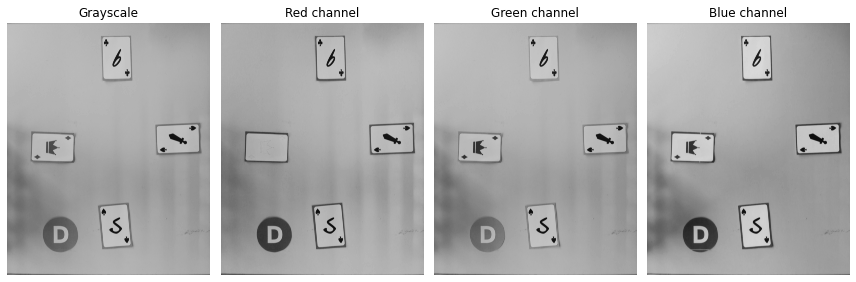

In [8]:
images = decompose_channels(image_cropped)

plot_channels(images)

In [9]:
from skimage.exposure import rescale_intensity
from skimage.filters import threshold_multiotsu, threshold_otsu

def norm_binary(image):
    # Normalizes the image and returns the binary version
    
    # Contrast stretching
    a, b = np.percentile(image, (0, 50))
    norm_im = rescale_intensity(image, in_range=(a,b))
    
    # Apply otsu method for threshold
    #threshold = threshold_otsu(norm_im)
    #binary = norm_im > threshold
    
    # Apply multiotsu
    threshold = threshold_multiotsu(norm_im)
    digitized = np.digitize(norm_im, bins=threshold)
    
    return digitized

In [10]:
# Normalize the 4 channels
binaries = [] 

for i in range(len(images)):
    binaries.append(norm_binary(images[i]))

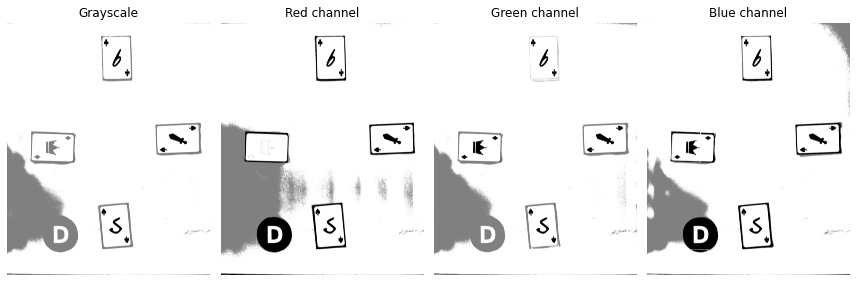

In [11]:
plot_channels(binaries)

We can see that the red channel seems to be the best channel to find the bounding boxes of the cards and the dealer token.

In [12]:
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, binary_erosion
from skimage.color import label2rgb
import matplotlib.patches as mpatches


def find_bbox(image, threshold=25000, plot=True):
    # Finds the bboxes of the objects (here the cards and dealer token)
    # Returns the number of bboxes 
    # and a dictionary of tuples (list_bbox_bounds, bbox_area, bbox_center)
    
    closed = closing(image, square(2))
    
    cleared = clear_border(closed)

    # label image regions
    label_image = label(cleared, background=0, connectivity=1)
    
    # Store bboxes
    bboxes = {}
    num = 0

    for region in regionprops(label_image):
        
        # take regions with large enough area
        if  region.area >= threshold:
            
            # Compute area of bbox
            minr, minc, maxr, maxc = region.bbox

            c = maxc - minc
            r = maxr - minr
            area = c * r
            
            # Compute bbox center
            xc = (minr + maxr) // 2
            yc = (minc + maxc) // 2
            
            bboxes[num] = ([minr, minc, maxr, maxc], area, [xc, yc])
            num += 1
    
    if plot:
        # Plot overlay of image regions and bboxes
        plot_overlays(image, label_image, threshold)
    
    return num, bboxes

def plot_overlays(image, label_image, threshold=25000):
    # Plot overlay of image regions and bboxes
    
    # plot label and image
    image_label_overlay = label2rgb(label_image, image=image, bg_label=0)
    
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image_label_overlay)

    for region in regionprops(label_image):
        # take regions with large enough areas
        
        if region.area >= threshold: # 25000
            
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

def get_centers(bboxes):
    # Get the centers of the bboxes of the cards only
    
    x_centers = []
    y_centers = []
    
    for i in range(len(bboxes.keys())):
        if bboxes[i][1] >= 200000: # Check if it's a card
            
            xc, yc = bboxes[i][2]
            
            x_centers.append(xc)
            y_centers.append(yc)
            
    return np.array(x_centers), np.array(y_centers)


def compute_distance(x1, y1, x2, y2):
    return np.sqrt(np.power(x1 - x2, 2)+np.power(y1 - y2, 2))

def remove_dup_bboxes(num, bboxes, threshold):
    # Remove bboxes inside others or overlaping
    # Remove a bbox if center is closer than threshold of another center
    # Only works if two overlapping bboxes
    
    # Keeps track of compared bboxes
    compared = np.zeros((num, num))
    
    # Index of bboxes to remove
    idx_remove = []
    
    for i in range(num):
        if bboxes[i][1] >= 200000: # Check if it's a card
            
            # Get first bbox center
            x1, y1 = bboxes[i][2]
            
            for j in range(num):
                
                # Compare only if never compared before
                if ((compared[i][j]==0) & (compared[j][i]==0) 
                     & (i!=j) & (bboxes[j][1] >= 200000)):
                    
                    # Get second bbox center
                    x2, y2 = bboxes[j][2]
                    
                    # Check if centers are too close
                    if compute_distance(x1, y1, x2, y2) <= threshold:
                        
                        # Record one with smaller area to remove later
                        area_i = bboxes[i][1]
                        area_j = bboxes[j][1]
                        
                        if area_i > area_j:
                            idx_remove.append(j)
                        else:
                            idx_remove.append(i)
                    
                    # Record that we compared i and j
                    compared[i][j] = 1
                    compared[j][i] = 1
    
    # Keep non overlaping bboxes
    bbox_filtered = {} 
    idx = 0
    for i in range(num):
        if i not in idx_remove:
            bbox_filtered[idx] = bboxes[i]
            idx += 1
    
    return idx, bbox_filtered
    
def rearrange_boxes(bboxes):
    
    # 0: Player1, 1: Player2 etc... 4: Dealer token
    boxes = {0: None, 1: None, 2: None, 3: None, 4: None}
    
    # If we have 1 dealer token and 4 cards
    if len(bboxes.keys()) == 5:
        xc, yc = get_centers(bboxes)
    
        min_x = np.min(xc)
        max_x = np.max(xc)
        min_y = np.min(yc)
        max_y = np.max(yc)
    
        for i in range(len(bboxes.keys())):
        
            # Check for dealer
            if bboxes[i][1] < 200000:
                boxes[4] = bboxes[i]
                
            else:
                
                x1, y1, x2, y2 = bboxes[i][0]
                x_c, y_c = bboxes[i][2]
                
                if x_c == min_x:
                    boxes[2] = bboxes[i]
                if x_c == max_x:
                    boxes[0] = bboxes[i]
                if y_c == min_y:
                    boxes[3] = bboxes[i]
                if y_c == max_y:
                    boxes[1] = bboxes[i]
                    
    # We have found less than 4 cards                
    else:
        
        # Dimensions of image
        height = 4300
        width = 3456
        
        # Divide height in 3 zones
        height_lim1 = height // 3
        height_lim2 = 2 * height_lim1
        
        # Divide width in 3 zones
        width_lim1 = width // 3
        width_lim2 = 2 * width_lim1
        
        # Go through each bbox and find it's position
        for i in range(len(bboxes.keys())):
            
            # Check for dealer
            if bboxes[i][1] < 200000:
                boxes[4] = bboxes[i]
                
            else:
                
                # Get centers
                x_c, y_c = bboxes[i][2]
                
                # If it's in top part, player 3
                if x_c < height_lim1:
                    boxes[2] = bboxes[i]
                    
                elif x_c > height_lim2: # If it's in bottom part, player1
                    boxes[0] = bboxes[i]
                    
                else: # It's either player 2 or player 4
                    
                    if y_c < width_lim1: # Player 4
                        boxes[3] = bboxes[i]
                        
                    else: # Player 2
                        boxes[1] = bboxes[i]
    return boxes

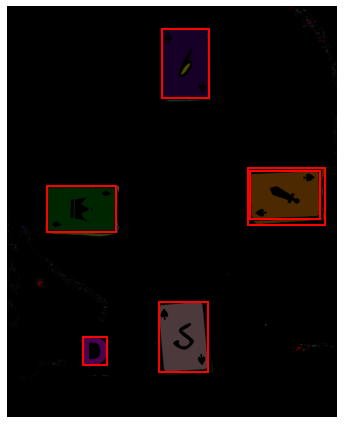

In [13]:
num, bboxes = find_bbox(binaries[3])

There are multiple bboxes for some of the cards, we need to remove them.

In [14]:
threshold = 100
num, bboxes = remove_dup_bboxes(num, bboxes, threshold)

boxes = rearrange_boxes(bboxes)

In [15]:
'''
# Remove 1 bbox to test
boxes_test = {}
idx = 0
for i in range(num):
    if i!=2:
        boxes_test[idx] = boxes[i]
        idx += 1
        
boxes = rearrange_boxes(boxes_test)
'''

'\n# Remove 1 bbox to test\nboxes_test = {}\nidx = 0\nfor i in range(num):\n    if i!=2:\n        boxes_test[idx] = boxes[i]\n        idx += 1\n        \nboxes = rearrange_boxes(boxes_test)\n'

We got the bounding boxes by following this tutorial : https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html#sphx-glr-auto-examples-segmentation-plot-label-py, we need to overlay them over the original image.

In [16]:
def plot_bbox(image, bboxes):
    # Plot the bboxes and class labels over the image
    
    # Display image
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(image)
    ax.axis('off')
    
    # Labels
    labels = {0: 'Player 1', 1: 'Player 2', 2: 'Player 3', 3: 'Player 4',
              4: 'Dealer'}

    for i in range(len(bboxes.keys())):
        
        if bboxes[i] != None:
            
            # Get bbox bounds
            minr, minc, maxr, maxc = bboxes[i][0]
        
            # Draw rectangle
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
        
            
            ax.text(minc, minr - 50, labels[i])
        
    plt.show()

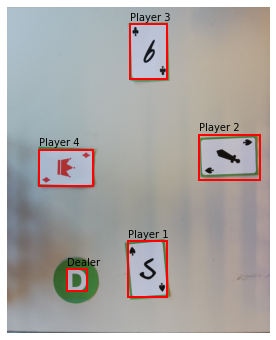

In [17]:
plot_bbox(image_cropped, boxes)

## CARD EXTRACTION

In [18]:
def extract_cards(img, bboxes):
    
    # 0: Player1, 1: Player2 etc...
    # We have to use empty arrays instead of None because images are arrays
    cards = {0: np.array([]), 1: np.array([]), 2: np.array([]), 3: np.array([])}
    
    for i in range(4):
        if bboxes[i] != None:
            x01, y01, x11, y11 = bboxes[i][0]
            cards[i] = img[x01:x11, y01:y11, :]
            
    return cards

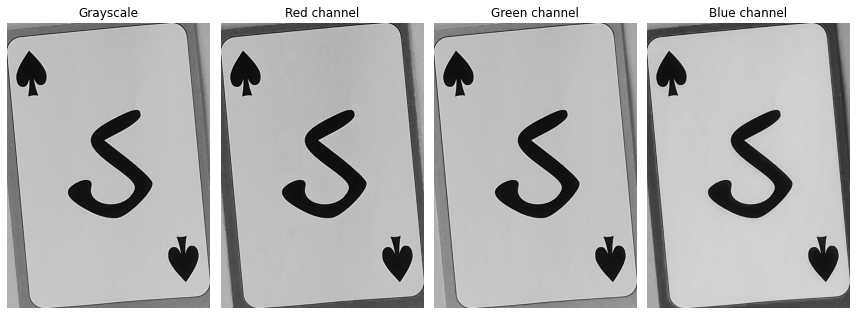

In [19]:
cards = extract_cards(image_cropped, boxes)

plot_channels(decompose_channels(cards[0]))

We will try to deblur or denoise image to see which one gives the best results

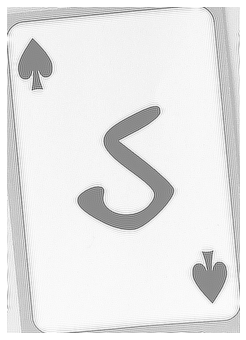

In [20]:
from skimage.restoration import unsupervised_wiener, richardson_lucy

# Kernel
psf = np.ones((4, 4)) / 20

# Denoise
deconvolved, _ = unsupervised_wiener(skimage.color.rgb2gray(cards[0]), psf)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.imshow(deconvolved, cmap='gray')
ax.axis('off')
plt.show()

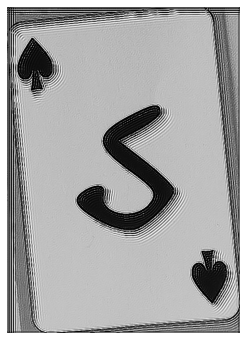

In [21]:
# Deblur
deconvolved_RL = richardson_lucy(skimage.color.rgb2gray(cards[0]), psf, iterations=40)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.imshow(deconvolved_RL, cmap='gray')
ax.axis('off')
plt.show()

The deblur / denoise algorithms don't seem to work well on the whole image

In [22]:
def find_distances(bboxes):
    distances = []
    
    x_center_dealer, y_center_dealer = bboxes[4][2]
    
    # Find distances of cards from dealer token
    for i in range(4):
        
        if bboxes[i] != None:
            x_center_p, y_center_p = bboxes[i][2]
            dist = compute_distance(x_center_p, y_center_p, x_center_dealer, y_center_dealer)
            distances.append(dist)
        
    return distances

def find_dealer(distances):
    return np.argmin(np.array(distances)) + 1

In [23]:
distances = find_distances(boxes)
dealer = find_dealer(distances)

In [24]:
import imutils

def rotate_cards(cards):
    
    # 0: Player1, 1: Player2 etc...
    # We have to use empty arrays instead of None because images are arrays
    cards_rotated = {0: np.array([]), 1: np.array([]), 2: np.array([]), 3: np.array([])}
    rotations = [0, 90, 180, -90]

    for i in range(4):
        if cards[i].size != 0:
            cards_rotated[i] = imutils.rotate_bound(cards[i], rotations[i])

    return cards_rotated

In [25]:
cards_rotated = rotate_cards(cards)

In [26]:
def plot_cards(cards, cmap='viridis'):

    fig, ax = plt.subplots(1, 4, figsize=(10, 5))
    
    for i in range(4):
        if cards[i].size!=0:
            ax[i].imshow(cards[i], cmap=cmap)
        ax[i].axis('off')

    plt.show()

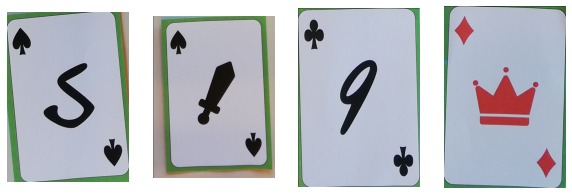

In [27]:
plot_cards(cards_rotated)

In [28]:
def binarize_cards(cards, channel=2):
    
    bin_cards = cards
    
    for i in range(len(cards)):
        
        if cards[i].size!=0:
        
            #Normalizes card
            norm = rescale_intensity(cards[i][:, :, channel])
        
            #Digitizes card
            th = threshold_multiotsu(norm)
            dig = np.digitize(norm, bins=th)
            bin_cards[i] = dig == 0 
        
    return bin_cards

In [29]:
bin_cards = binarize_cards(cards_rotated)

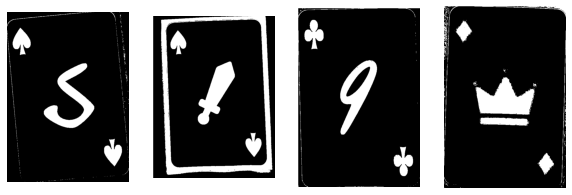

In [30]:
#Plot cards
plot_cards(bin_cards, 'gray')

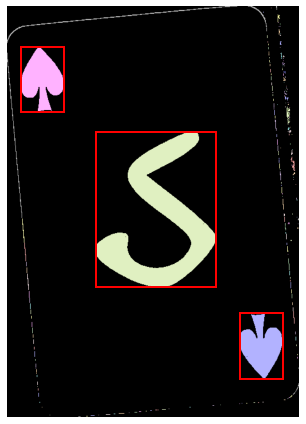

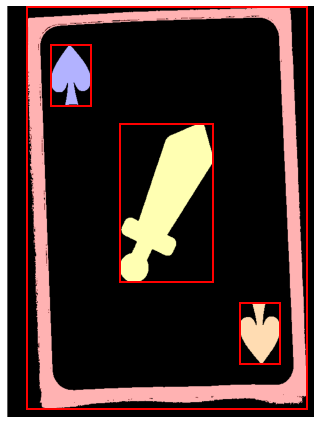

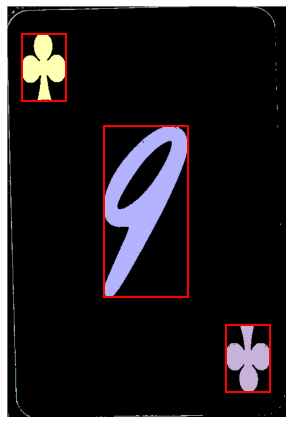

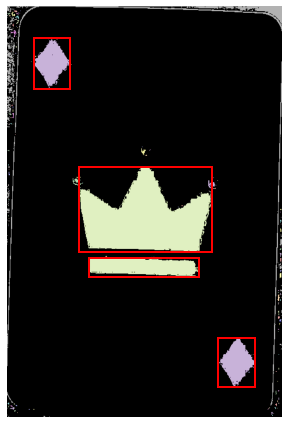

In [31]:
num_p1, boxes_p1 = find_bbox(bin_cards[0], 2000)
num_p2, boxes_p2 = find_bbox(bin_cards[1], 2000)
num_p3, boxes_p3 = find_bbox(bin_cards[2], 2000)
num_p4, boxes_p4 = find_bbox(bin_cards[3], 2000)

## SUITE EXTRACTION

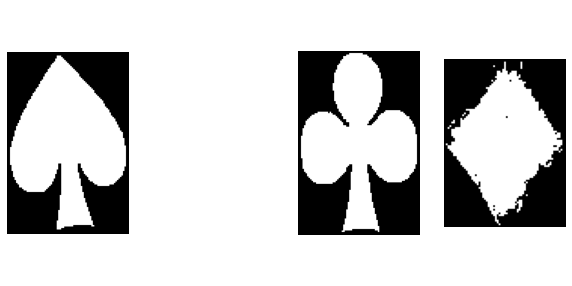

In [32]:
#Suits extraction
sx11, sy11, sx21, sy21 = boxes_p1[0][0]
suit_p1 = bin_cards[0][sx11-3:sx21+3, sy11-2:sy21+2]
sx12, sy12, sx22, sy22 = boxes_p2[0][0]
suit_p2 = bin_cards[1][sx12-2:sx22+2, sy12-2:sy22+2]
sx13, sy13, sx23, sy23 = boxes_p3[0][0]
suit_p3 = bin_cards[2][sx13-2:sx23+2, sy13-2:sy23+2]
sx14, sy14, sx24, sy24 = boxes_p4[0][0]
suit_p4 =bin_cards[3][sx14-2:sx24+2, sy14-2:sy24+2]

suits = [suit_p1, suit_p2, suit_p3, suit_p4]
plot_cards(suits, 'gray')

We should perform binary morphology on the contours to make them clearer

In [33]:
from skimage.morphology import opening, disk, octagon

'''
for i in range(len(suits)):
    
        suits[i] = closing(suits[i], square(2))
        suits[i] = opening(suits[i], disk(2))
    
plot_cards(suits, 'gray')

from skimage.transform import resize

size = (300,300)
suitp1 = resize(suits[0], size)
suitp2 = resize(suits[1], size)
suitp3 = resize(suits[2], size)
suitp4 = resize(suits[3], size)

suits_resized = [suitp1, suitp2, suitp3, suitp4]
plot_cards(suits_resized, 'gray')

#Digits extraction
dx11, dy11, dx21, dy21 = boxes_p1[1][0]
rank_p1 = bin_cards[0][dx11-20:dx21+20, dy11-20:dy21+20]
dx12, dy12, dx22, dy22 = boxes_p2[1][0]
rank_p2 = bin_cards[1][dx12-20:dx22+20, dy12-20:dy22+20]
dx13, dy13, dx23, dy23 = boxes_p3[1][0]
rank_p3 = bin_cards[2][dx13-20:dx23+20, dy13-20:dy23+20]
dx14, dy14, dx24, dy24 = boxes_p4[1][0]
rank_p4 = bin_cards[3][dx14-20:dx24+20, dy14-20:dy24+20]

ranks = [rank_p1, rank_p2, rank_p3, rank_p4]
plot_cards(ranks, 'gray')

# Opening
for i in range(len(ranks)):
    
    ranks[i] = closing(ranks[i], disk(2))
    ranks[i] = opening(ranks[i], disk(4))
    
plot_cards(ranks, 'gray')

rankp1 = resize(rank_p1, size)
rankp2 = resize(rank_p2, size)
rankp3 = resize(rank_p3, size)
rankp4 = resize(rank_p4, size)

plot_cards([rankp1, rankp2, rankp3, rankp4], 'gray')
'''

"\nfor i in range(len(suits)):\n    \n        suits[i] = closing(suits[i], square(2))\n        suits[i] = opening(suits[i], disk(2))\n    \nplot_cards(suits, 'gray')\n\nfrom skimage.transform import resize\n\nsize = (300,300)\nsuitp1 = resize(suits[0], size)\nsuitp2 = resize(suits[1], size)\nsuitp3 = resize(suits[2], size)\nsuitp4 = resize(suits[3], size)\n\nsuits_resized = [suitp1, suitp2, suitp3, suitp4]\nplot_cards(suits_resized, 'gray')\n\n#Digits extraction\ndx11, dy11, dx21, dy21 = boxes_p1[1][0]\nrank_p1 = bin_cards[0][dx11-20:dx21+20, dy11-20:dy21+20]\ndx12, dy12, dx22, dy22 = boxes_p2[1][0]\nrank_p2 = bin_cards[1][dx12-20:dx22+20, dy12-20:dy22+20]\ndx13, dy13, dx23, dy23 = boxes_p3[1][0]\nrank_p3 = bin_cards[2][dx13-20:dx23+20, dy13-20:dy23+20]\ndx14, dy14, dx24, dy24 = boxes_p4[1][0]\nrank_p4 = bin_cards[3][dx14-20:dx24+20, dy14-20:dy24+20]\n\nranks = [rank_p1, rank_p2, rank_p3, rank_p4]\nplot_cards(ranks, 'gray')\n\n# Opening\nfor i in range(len(ranks)):\n    \n    ranks[i] 

## SUITE EXTRACTION FUNCTIONS

In [34]:
from skimage.transform import resize

def extraction(cards, bplot=False):
    
    # 0: Player1, 1: Player2 etc...
    # Each image has two images of its suit. We store both as list [suit1, suit2]
    extracted_suites = {0: None, 1: None, 2: None, 3: None}
    size_suite = (300, 300)
    
    # We have to use empty arrays instead of None because we directly store the images of the digits
    extracted_ranks = {0: np.array([]), 1: np.array([]), 2: np.array([]), 3: np.array([])}
    size_rank = (28, 28) # Same size as MNIST images
    
    for i in range(4):
        if cards[i].size!=0:
            
            # Remove holes inside object
            card = card_morpho(cards[i])
            
            # Find bbox of objects on card
            num, boxes = find_bbox(card, 2000, bplot)
            
            # Get suits + digit bboxes
            rank, suites = get_suit_rank(boxes)
            
            im_suites = []
            
            # Second suit is upside down need to flip it
            rotations = [0, 180, 0, 0 , 0] # Added exta 0 in case len suites > 2
            
            # Get shape of card
            height, width = card.shape
            
            # Get image of suits
            for j in range(len(suites)):
    
                dx1, dy1, dx2, dy2 = suites[j][0]
        
                # Check that we don't select out of bounds of the image
                incr = 5
                if (dx1-incr > 0) & (dx2 + incr < height) & (dy1-incr > 0) & (dy2+incr < width):
                    dx1 -= incr
                    dx2 += incr
                    dy1 -= incr
                    dy2 += incr
                
                ## Check not out of bounds
                # Mathematical morphology
                im_suite = suite_morpho(card[dx1:dx2, dy1:dy2])
                im_suite = resize(im_suite, size_suite)
                
                im_suites.append(imutils.rotate_bound(np.float32(im_suite), rotations[j]))
            
            # Add suites of image i to extracted_suites
            extracted_suites[i] = im_suites
            
            # Get image of rank
            dx1, dy1, dx2, dy2 = rank[0]
            
            # Check that we don't select out of bounds of the image
            incr = 60
            if (dx1-incr > 0) & (dx2 + incr < height) & (dy1-incr > 0) & (dy2+incr < width):
                dx1 -= incr
                dx2 += incr
                dy1 -= incr
                dy2 += incr
            
            # Mathematical morphology
            im_rank = rank_morpho(card[dx1:dx2, dy1:dy2])
            im_rank = resize(im_rank, size_rank)
            
            extracted_ranks[i] = im_rank
            
    return extracted_ranks, extracted_suites

def get_suit_rank(bboxes):
    # Labels bboxes as suit or rank
    
    num_bboxes = len(bboxes.keys())
    
    # Store bbox areas
    areas = np.empty(num_bboxes)
    
    for i in range(num_bboxes):
        # Sometimes card is detected, we don't keep it
        if bboxes[i][1] > 80000:
            areas[i] = -1
        else:
            areas[i] = bboxes[i][1]
        
    # Biggest area is that of digit bbox
    idx_rank = np.argmax(areas)
    
    rank = bboxes[idx_rank]
    
    suites = [bboxes[i] for i in bboxes.keys() if ((i!=idx_rank) & (areas[i]>0))]
    
    len_suites = len(suites)
    
    # If we have found 2 suites or less return them
    if len_suites <= 2:
        return rank, suites
    
    # Otherwise need to filter to keep 2. Happens when we detect a king (2 bboxes for the king symbol)
    # Merge detected suite closer to the rank as part of the rank (it's small rectangle below king)
    else:
        distances = np.empty(len_suites)
        
        for i in range(len_suites):
            distances[i] = compute_distance(rank[2][0], rank[2][1], suites[i][2][0], suites[i][2][1])
        
        # Get index of smallest distance
        idx_min = np.argmin(distances)
        
        # Merge bbox with the rank if close enough
        # We make assumption that bbox to merge is below the rank (i.e small rectangle of king)
        if distances[idx_min] < 100:
            rx1, ry1, rx2, ry2 = rank[0]
            cx1, cy1, cx2, cy2 = suites[idx_min][0]
            rank = ([rx1-18, ry1, cx2, ry2], bboxes[idx_rank][1], bboxes[idx_rank][2])
            suites_ = [suites[i] for i in range(len_suites) if (i!=idx_min)]
            
        # If it wasn't close enough, we picked up a "suite" that is not a suite
        # We make the assumption that this "suite" is an artifact that belongs to the borders of the cards
        # Thus the true suites are two closest from rank
        else:
            
            suites_ = [suites[idx_min]]
            distances[idx_min] = np.float('inf')
            suites_.append(suites[np.argmin(distances)])
            
        return rank, suites_

In [35]:
from skimage.morphology import opening, disk

def suite_morpho(suite):
    
    im_suite = closing(suite, square(2))
    im_suite = opening(im_suite, disk(2))
    
    return im_suite

def rank_morpho(rank):
    
    im_rank = closing(rank, disk(2))
    im_rank = opening(im_rank, disk(4))
    
    return im_rank

def card_morpho(card):
    
    im_card = closing(card, disk(3))
    
    return im_card

In [36]:
ranks, suites = extraction(cards_rotated)

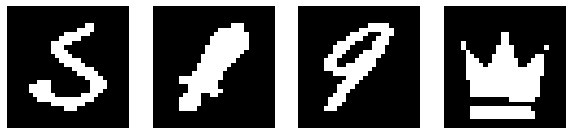

In [37]:
plot_cards(ranks, 'gray')

In [38]:
def plot_suites(suites, cmap='gray'):

    fig, ax = plt.subplots(2, 4, figsize=(10, 5))
    
    for i in range(4):
        if suites[i]!=None:
            for j in range(len(suites[i])):
                ax[j][i].imshow(suites[i][j], cmap=cmap)
        ax[0][i].axis('off')
        ax[1][i].axis('off')

    plt.show()

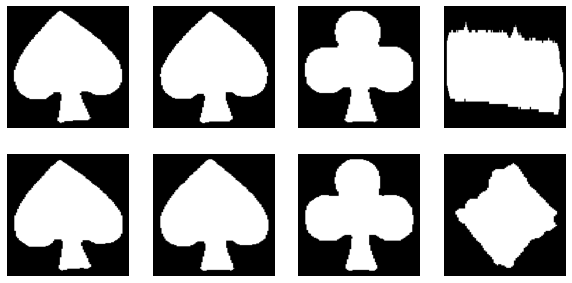

In [39]:
plot_suites(suites)

In [40]:
def round_to_elems(img, bplot=False):
    image_cropped = crop(img)

    #decompose channels
    images = decompose_channels(image_cropped)

    #normalize the 4 channels
    binaries = [] 
    for i in range(len(images)):
        binaries.append(norm_binary(images[i]))

    #boxes on blue channel
    num, bboxes = find_bbox(binaries[3], plot=False)

    #rearrange boxes
    threshold = 100
    num, bboxes = remove_dup_bboxes(num, bboxes, threshold)
    boxes = rearrange_boxes(bboxes)

    #extract cards
    cards = extract_cards(image_cropped, boxes)

    #rotate cards
    cards_rotated = rotate_cards(cards)
    bin_cards = binarize_cards(cards_rotated)

    #ranks and suites extraction
    ranks, suites = extraction(bin_cards, bplot)
    
    return ranks, suites

## Training set

#### Extracting all ranks and suites (WIP)

In [41]:
import re
import pickle

data_base_path = os.path.join(os.pardir, 'project/train_games')
save_folder = "train_set/"

# Only include JQK
ranks_im = []
ranks_label = []

suites_im = []
suites_label = []

for root, dirs, files in os.walk(data_base_path):
    
    m = re.search(r'game(\d+$)', root)
    name_game = ''
    if m:
        name_game = m.group(0)
        df_csv = pd.read_csv((root+'/'+name_game+'.csv'))
        print(name_game)
    
    for i in range(len(files)-1):
        if files[i].endswith(".jpg"):
            
            # Find the round number
            num_round = int(files[i][:-4])
            print(num_round)

            img = skimage.io.imread(os.path.join(root, files[i]))
            
            ranks, suites = round_to_elems(img)
            
            for idx_player in range(4):
                label_im = df_csv.iloc[num_round-1, idx_player+1]
                label_rank = label_im[0]
                label_suite = label_im[1]
            
                if (ranks[idx_player].size!=0) & (label_rank in ['J', 'Q', 'K']):
                    ranks_im.append(ranks[idx_player].flatten())
                    ranks_label.append(label_rank)
                
                if (suites[idx_player]!=None):
                    
                    suites_list = suites[idx_player]
                    
                    # Store both suites and remove incorrect one later
                    for j in range(len(suites_list)):
                        suites_im.append((suites_list[j].flatten()))
                        suites_label.append(label_suite)
                        
                
# Convert ranks_im and suites_im to numpy arrays
ranks_im = np.asarray(ranks_im)
suites_im = np.asarray(suites_im)

# Save ranks_im + ranks_label
np.save(save_folder+'ranks_im.npy', ranks_im)
with open(save_folder+"ranks_label.txt", "wb") as fp:   #Pickling
    pickle.dump(ranks_label, fp)
    
# Save suites_im + suites_label
np.save(save_folder+'suites_im.npy', suites_im)
with open(save_folder+"suites_label.txt", "wb") as fp2:   #Pickling
    pickle.dump(suites_label, fp2)

game5
8
9
12
13
11
10
4
5
7
6
2
3
game2
8
9
12
13
11
10
4
5
7
6
2
3
game3
8
9
12
13
11
10
4
5
7
6
2
3
game4
8
9
12
13
11
10
4
5
7
6
2
3
game1
8
9
12
13
11
10
4
5
7
6
2
3
game6
8
9
12
13
11
10
4
5
7
6
2
3
game7
8
9
12
13
11
10
4
5
7
6
2
3


#### Open back files and remove incorrect images

In [42]:
import pickle
# Open rank files
ranks_images = np.load(save_folder+'ranks_im.npy')
with open(save_folder+"ranks_label.txt", "rb") as fp:   # Unpickling
    ranks_label_op = pickle.load(fp)

# Open suite files
suites_images = np.load(save_folder+'suites_im.npy')
with open(save_folder+"suites_label.txt", "rb") as fp2:   # Unpickling
    suites_label_op = pickle.load(fp2)

##### Check rank images

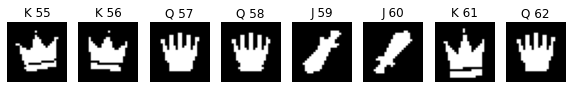

In [43]:
ranks_shape = (28, 28)

fig, ax = plt.subplots(1, 8, figsize = (10,10))

start = 55
end = start + 8
idx = 0
for i in range(start, end):
    ax[idx].imshow(ranks_images[i].reshape(ranks_shape), cmap='gray')
    ax[idx].set_title(ranks_label_op[i] + " "+ str(i))
    ax[idx].axis('off')
    idx += 1

We need to flip the J at index 59

In [44]:
ranks_images[59] = imutils.rotate(ranks_images[59].reshape(ranks_shape), 180).flatten()

We can save the images of the ranks again.

In [45]:
np.save(save_folder+'ranks_im.npy', ranks_images)

##### Check suite images

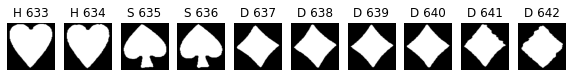

In [46]:
suites_shape = (300, 300)

fig, ax = plt.subplots(1, 10, figsize = (10,12))

start = 633
end = start + 10
idx = 0
for i in range(start, end):
    ax[idx].imshow(suites_images[i].reshape(suites_shape), cmap='gray')
    ax[idx].set_title(suites_label_op[i] + " "+ str(i))
    ax[idx].axis('off')
    idx += 1

Idx to remove : 48, 52, 54, 58, 62, 66, 94, 117, 129, 137, 170, 198, 237, 247, 248, 271, 275, 279, 285, 305, 319, 371, 391, 395, 447, 455, 484, 495, 521, 550, 579, 629
Idx to flip : 49, 53, 55, 59, 63, 67, 95, 110, 130, 138, 171, 199, 272, 286, 320, 372, 392, 396, 448, 496, 497, 522, 556, 580, 630

Second suite seems better than 1st

In [47]:
idx_remove = [48, 52, 54, 58, 62, 66, 94, 117, 129, 137, 170,
              198, 237, 247, 248, 271, 275, 279, 285, 305, 319,
              371, 391, 395, 447, 455, 484, 495, 521, 550, 579, 629]

idx_flip = [49, 53, 55, 59, 63, 67, 95, 110, 130, 138, 171, 199, 272,
            286, 320, 372, 392, 396, 448, 496, 497, 522, 556, 580, 630]

# First flip images to flip
for idx in idx_flip:
    suites_images[idx] = imutils.rotate(suites_images[idx].reshape(suites_shape), 180).flatten()

In [48]:
# Remove images and labels
new_suites_im = []
new_suites_labels = []

for i in range(len(suites_label_op)):
    if i not in idx_remove:
        new_suites_im.append(suites_images[i])
        new_suites_labels.append(suites_label_op[i])

new_suites_images = np.asarray(new_suites_im)

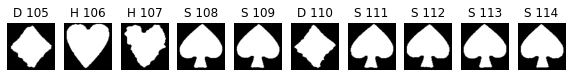

In [49]:
# Check correct changes

fig, ax = plt.subplots(1, 10, figsize = (10,12))

start = 105
end = start + 10
idx = 0
for i in range(start, end):
    ax[idx].imshow(new_suites_images[i].reshape(suites_shape), cmap='gray')
    ax[idx].set_title(new_suites_labels[i] + " "+ str(i))
    ax[idx].axis('off')
    idx += 1

We can save the changes

In [50]:
# Save suites_im + suites_label
np.save(save_folder+'suites_im.npy', new_suites_images)
with open(save_folder+"suites_label.txt", "wb") as fp2:   #Pickling
    pickle.dump(new_suites_labels, fp2)